# []

In [1]:
# inbuilt 
import os
import sys
import math

# most common
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch as tt
import torch.nn as nn
import torch.optim as oo
import torch.functional as ff
import torch.distributions as dd
import torch.utils.data as ud

# custom
import known
from known.basic import pj
from known.basic.common import Verbose as verb
import known.ktorch as kt

print(f'{sys.version=}\n{np.__version__=}\n{tt.__version__=}\n{known.__version__=}')

sys.version='3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]'
np.__version__='1.22.2'
tt.__version__='1.10.1+cu102'
known.__version__='0.0.1'


# Select DataSet

## (1) Sinus

In [2]:
seqlen = 10
cols = ('1','2', '3')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/sinu.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/sinu_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/sinu_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x21435938100>,
 <known.ktorch.data.SeqDataset at 0x21460b9d460>)

# (2) custom - g

In [3]:
seqlen = 25
cols = ('1','2')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/g.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/g_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/g_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x2143b9ce130>,
 <known.ktorch.data.SeqDataset at 0x21439f34e80>)

# (3) custom - h

In [4]:
seqlen = 40
cols = ('1','2')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/h.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/h_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/h_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x21439f649d0>,
 <known.ktorch.data.SeqDataset at 0x21460b6fca0>)

# Define Regression Network

In [5]:
dt = tt.float32
dropout=0.0
batch_first = True
num_layers = 2
hidden_size = 32
bidirectional = True
bias = True


i2h_sizes = [hidden_size for _ in range(num_layers)]
fc_layers = []
fc_bias=True
fc_act=(nn.ReLU, {})

i2o_sizes=None
o2o_sizes=None

In [15]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, heads, d_model, dropout):
        super(TimeSeriesTransformer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.heads = heads
        self.d_model = d_model
        self.dropout = dropout
        
        # Define the embedding layer
        self.embedding = nn.Linear(input_size, d_model)
        
        # Define the transformer layers
        self.transformer_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(num_layers)])
        
        # Define the output layer
        self.output_layer = nn.Linear(d_model, output_size)
        
    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        
        # Pass the embedded input through the transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Pass the transformer output through the output layer
        x = self.output_layer(x)
        
        return x


In [21]:
m = TimeSeriesTransformer(input_size=1, output_size=1, num_layers=2, heads=8, d_model=128, dropout=0.0)
m

TimeSeriesTransformer(
  (embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dro

In [24]:
with tt.no_grad():
    y = m(tt.rand((5, 24, 1)))
y.shape, y

(torch.Size([5, 24, 1]),
 tensor([[[-0.0251],
          [ 0.1878],
          [-0.1249],
          [ 0.0840],
          [-0.1142],
          [-0.0378],
          [ 0.0322],
          [-0.0051],
          [ 0.1388],
          [-0.0644],
          [ 0.0650],
          [-0.0089],
          [ 0.0954],
          [-0.1276],
          [-0.0747],
          [ 0.0581],
          [-0.0277],
          [-0.1316],
          [-0.1020],
          [ 0.0532],
          [ 0.1742],
          [ 0.0711],
          [ 0.1529],
          [ 0.1875]],
 
         [[ 0.0128],
          [ 0.1501],
          [-0.0159],
          [-0.1564],
          [-0.1376],
          [-0.1611],
          [-0.0388],
          [-0.0128],
          [ 0.0610],
          [ 0.1348],
          [ 0.1141],
          [ 0.1480],
          [ 0.1156],
          [-0.1180],
          [-0.0144],
          [ 0.2158],
          [-0.0465],
          [ 0.0427],
          [-0.1081],
          [-0.1121],
          [-0.0101],
          [-0.0741],
      

## encapsulate rnns

In [6]:
networks = dict(


elman_kt = kt.RegressionRNN(kt.ELMAN,
        input_size=input_size,      
        i2h_sizes=i2h_sizes,      
        i2o_sizes=i2o_sizes,  
        o2o_sizes=o2o_sizes,  
        dropout=0.0,        
        batch_first=batch_first,  
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        hypers=None,
        bidir = bidirectional,
        fc_layers=fc_layers,
        fc_bias=fc_bias,
        fc_act=fc_act,
        dtype=dt,
        device=None),
    

gru_kt = kt.RegressionRNN(kt.GRU,
        input_size=input_size,      
        i2h_sizes=i2h_sizes,      
        i2o_sizes=i2o_sizes,  
        o2o_sizes=o2o_sizes,   
        dropout=0.0,        
        batch_first=batch_first,  
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        hypers=None,
        bidir = bidirectional,
        fc_layers=fc_layers,
        fc_bias=fc_bias,
        fc_act=fc_act,
        dtype=dt,
        device=None),

lstm_kt = kt.RegressionRNN(kt.LSTM,
        input_size=input_size,      
        i2h_sizes=i2h_sizes,      
        i2o_sizes=i2o_sizes,  
        o2o_sizes=o2o_sizes,   
        dropout=0.0,        
        batch_first=batch_first,  
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        hypers=None,
        bidir = bidirectional,
        fc_layers=fc_layers,
        fc_bias=fc_bias,
        fc_act=fc_act,
        dtype=dt,
        device=None),

mgu_kt = kt.RegressionRNN(kt.MGU,
        input_size=input_size,      
        i2h_sizes=i2h_sizes,      
        i2o_sizes=i2o_sizes,  
        o2o_sizes=o2o_sizes,   
        dropout=0.0,        
        batch_first=batch_first,  
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        hypers=None,
        bidir = bidirectional,
        fc_layers=fc_layers,
        fc_bias=fc_bias,
        fc_act=fc_act,
        dtype=dt,
        device=None),

janet_kt = kt.RegressionRNN(kt.JANET,
        input_size=input_size,      
        i2h_sizes=i2h_sizes,      
        i2o_sizes=i2o_sizes,  
        o2o_sizes=o2o_sizes,   
        dropout=0.0,        
        batch_first=batch_first,  
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        hypers=None,
        bidir = bidirectional,
        fc_layers=fc_layers,
        fc_bias=fc_bias,
        fc_act=fc_act,
        dtype=dt,
        device=None),

)

colors = {k:v for k,v in zip(networks.keys(), \
            [ 'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown' ])}

# (A) Train and Evaluate

elman_kt <class 'known.ktorch.rnn.RegressionRNN'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 05:30:34.276623
-------------------------------------------
-------------------------------------------
Final Training Loss: [0.00020692081307061017]
Final Validation Loss: [0.0005707194795832038]
End Training @ 2023-01-24 05:30:43.927743, Elapsed Time: [0:00:09.651120]


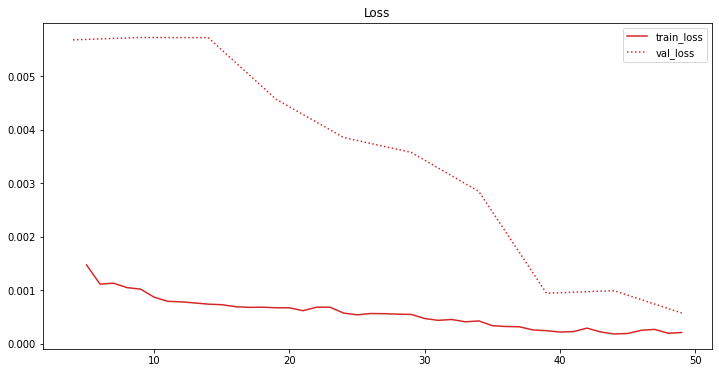

Testing samples: [460]
Testing batches: [1]
(~)	Loss: 0.00034051103284582496
gru_kt <class 'known.ktorch.rnn.RegressionRNN'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 05:30:44.055813
-------------------------------------------
-------------------------------------------
Final Training Loss: [0.000361070764483884]
Final Validation Loss: [0.0031808337662369013]
End Training @ 2023-01-24 05:31:15.155574, Elapsed Time: [0:00:31.099761]


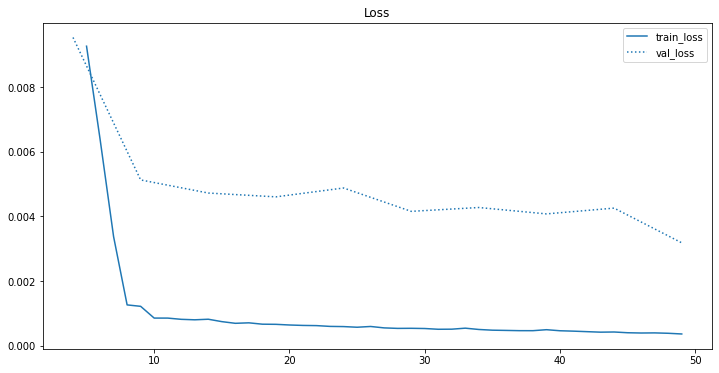

Testing samples: [460]
Testing batches: [1]
(~)	Loss: 0.005797408986836672
lstm_kt <class 'known.ktorch.rnn.RegressionRNN'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 05:31:15.340843
-------------------------------------------
-------------------------------------------
Final Training Loss: [0.0005960458656772971]
Final Validation Loss: [0.0036963606253266335]
End Training @ 2023-01-24 05:31:50.109932, Elapsed Time: [0:00:34.769089]


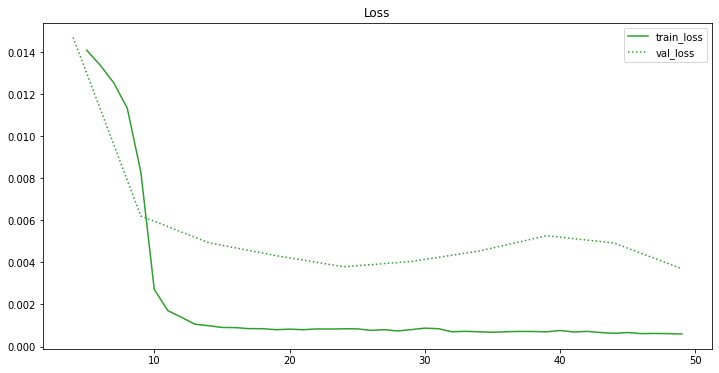

Testing samples: [460]
Testing batches: [1]
(~)	Loss: 0.005152522586286068
mgu_kt <class 'known.ktorch.rnn.RegressionRNN'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 05:31:50.296881
-------------------------------------------
-------------------------------------------
Final Training Loss: [0.00043829894275404513]
Final Validation Loss: [0.0027165596839040518]
End Training @ 2023-01-24 05:32:15.316633, Elapsed Time: [0:00:25.019752]


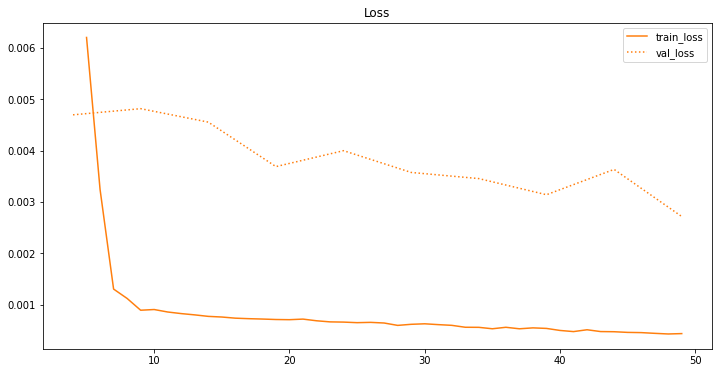

Testing samples: [460]
Testing batches: [1]
(~)	Loss: 0.004009189084172249
janet_kt <class 'known.ktorch.rnn.RegressionRNN'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 05:32:15.462072
-------------------------------------------
-------------------------------------------
Final Training Loss: [0.00023249757941812277]
Final Validation Loss: [0.002429294865578413]
End Training @ 2023-01-24 05:32:39.549686, Elapsed Time: [0:00:24.087614]


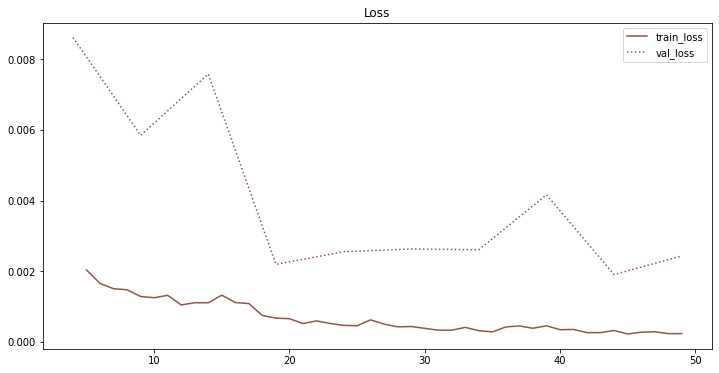

Testing samples: [460]
Testing batches: [1]
(~)	Loss: 0.0036879663821309805


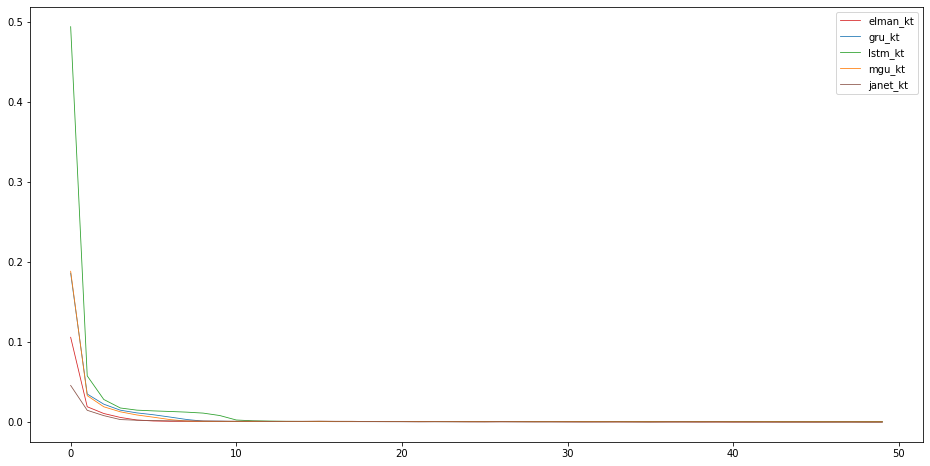

In [7]:
test_loss, train_loss = {}, {}
for key,model in networks.items():
    print(key, model.__class__)

    model.do_compile(optimizerF=oo.Adam, optimizerA=dict(lr=0.0025, weight_decay=0.0), 
                    criterionF=nn.MSELoss, criterionA=None)
    
    epochs = 50
    batch_size=32
    shuffle=True
    validation_freq = int(epochs/10)
    lrs=oo.lr_scheduler.LinearLR(model.optimizer, start_factor= 1.0, end_factor=0.7, total_iters=epochs)
    #loss_plot_start = int(epochs/50)
    train_loss_history, val_loss_history = model.do_train(training_data=ds_train, validation_data=ds_val, 
            epochs=epochs, batch_size=batch_size, shuffle=shuffle, 
            validation_freq=validation_freq, lrs=None, verbose=1, 
            plot=True, color=colors[key], )

    #early_stop_train=kt.QuantiyMonitor('TrainLoss', patience=50, delta=0.00001)
    #early_stop_val=kt.QuantiyMonitor('ValLoss', patience=50, delta=0.00001)
    #checkpoint_freq=int(epochs/4)
    save_path=f'{key}.reg'

    mtl, _ = model.do_test(ds_test, batch_size=None)
    train_loss[key] = train_loss_history.numpy()
    test_loss[key] = mtl
    print('=================================================')
    
plt.figure(figsize=(16,8))
for k,v in train_loss.items():
    plt.plot(np.mean(v, axis=1), label=k, color=colors[k], linewidth=0.8)
plt.legend()
plt.show()

# (B) Load and Evaluate

In [ ]:
for key,model in networks.items():
    kt.load_state(model, f'{key}.reg')
test_loss={}

for key,model in networks.items():
    mtl, tl = model.do_test(ds_test)

    test_loss[key] = mtl

# Plot Evaluation Results

elman_kt:	0.00034051103284582496
gru_kt:	0.005797408986836672
lstm_kt:	0.005152522586286068
mgu_kt:	0.004009189084172249
janet_kt:	0.0036879663821309805


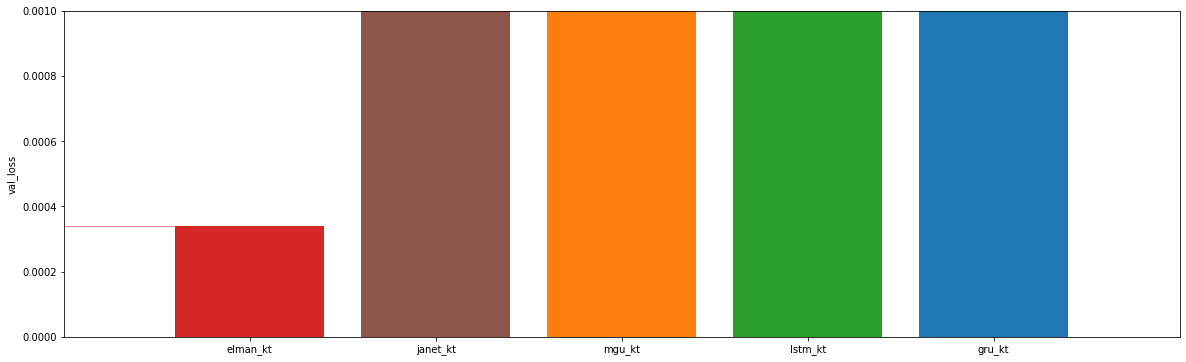

In [8]:
y = []
l = []
c = []
for k,v in test_loss.items():
    print(f'{k}:\t{v}')
    y.append(v)
    l.append(k)
    c.append(colors[k])

x= range(len(test_loss))

y = np.array(y)
l = np.array(l)
t = np.argsort(y)

plt.figure(figsize=(20,6))
plt.xlim(-1,len(x))
plt.ylim(0,0.001)
for i in t:
    plt.bar([i] , y[t[i]], color=c[t[i]] )
    plt.hlines(y[t[i]], -1, i, linestyles='solid', linewidth=0.5, color=c[t[i]])
plt.xticks(x, l[t])
plt.ylabel('val_loss')
plt.show()

# Manual Testing

## test dataset

In [9]:
res = {}
for key,model in networks.items():
    print(key, model.__class__)
    model.eval()
    with tt.no_grad():
        dl = iter(ds_test.dataloader(batch_size=int(len(ds_test)*1.0)))
        Xv, Yv = next(dl)
        Pv = model(Xv)
        res[key]=Pv #print(Xv.shape, Yv.shape, Pv.shape)



elman_kt <class 'known.ktorch.rnn.RegressionRNN'>
gru_kt <class 'known.ktorch.rnn.RegressionRNN'>
lstm_kt <class 'known.ktorch.rnn.RegressionRNN'>
mgu_kt <class 'known.ktorch.rnn.RegressionRNN'>
janet_kt <class 'known.ktorch.rnn.RegressionRNN'>


## visualize

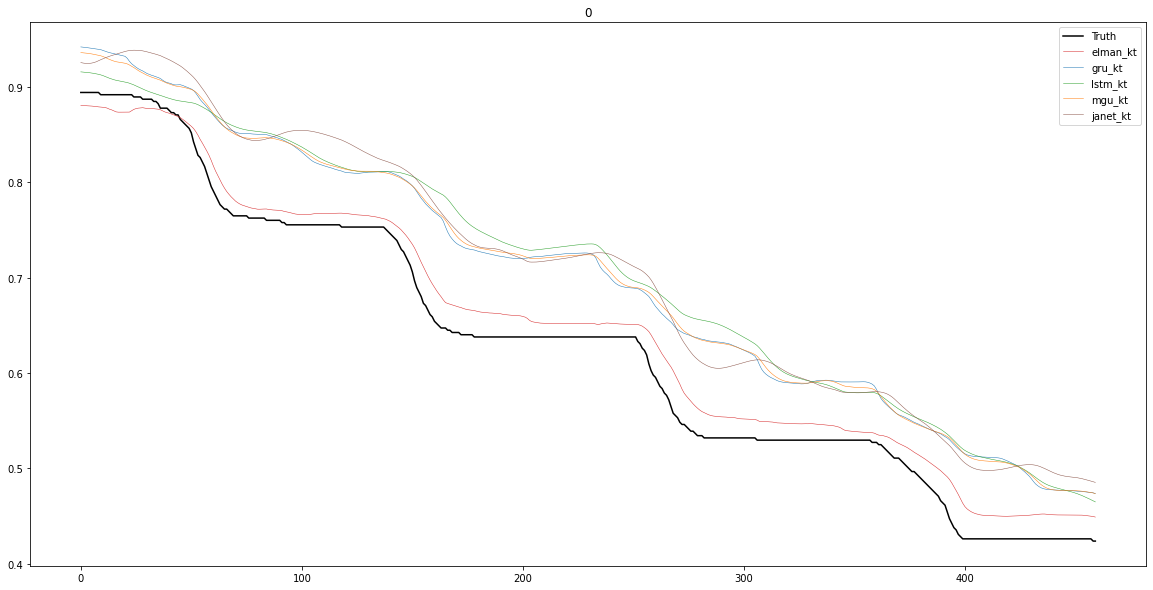

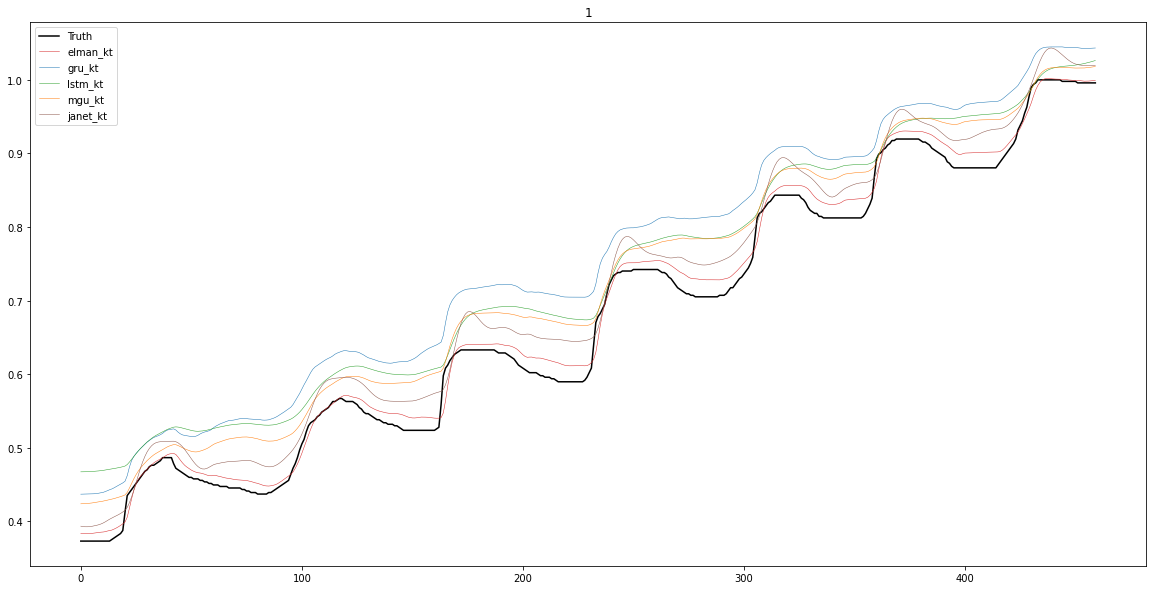

In [10]:
for i in range(input_size):
    plt.figure(figsize=(20,10))
    plt.title(f'{i}')
    
    plt.plot(Yv[:,i], color='black', label='Truth')
    for key,r in res.items():
        plt.plot(r[:,i], color=colors[key], label=f'{key}', linewidth=0.5)
    plt.legend()
    plt.show()
    plt.close()
    print('=================================================')